# Activity
## (Tuesday)

### Linear Regression
- X-y split (y is the target variable, which is the total claim amount)
- Train-test split.
- Standardize the data (after the data split).
- Apply linear regression.
- Model Interpretation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [3]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

In [4]:
dmca_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round3.csv")


#### plotting the correlation heatmap

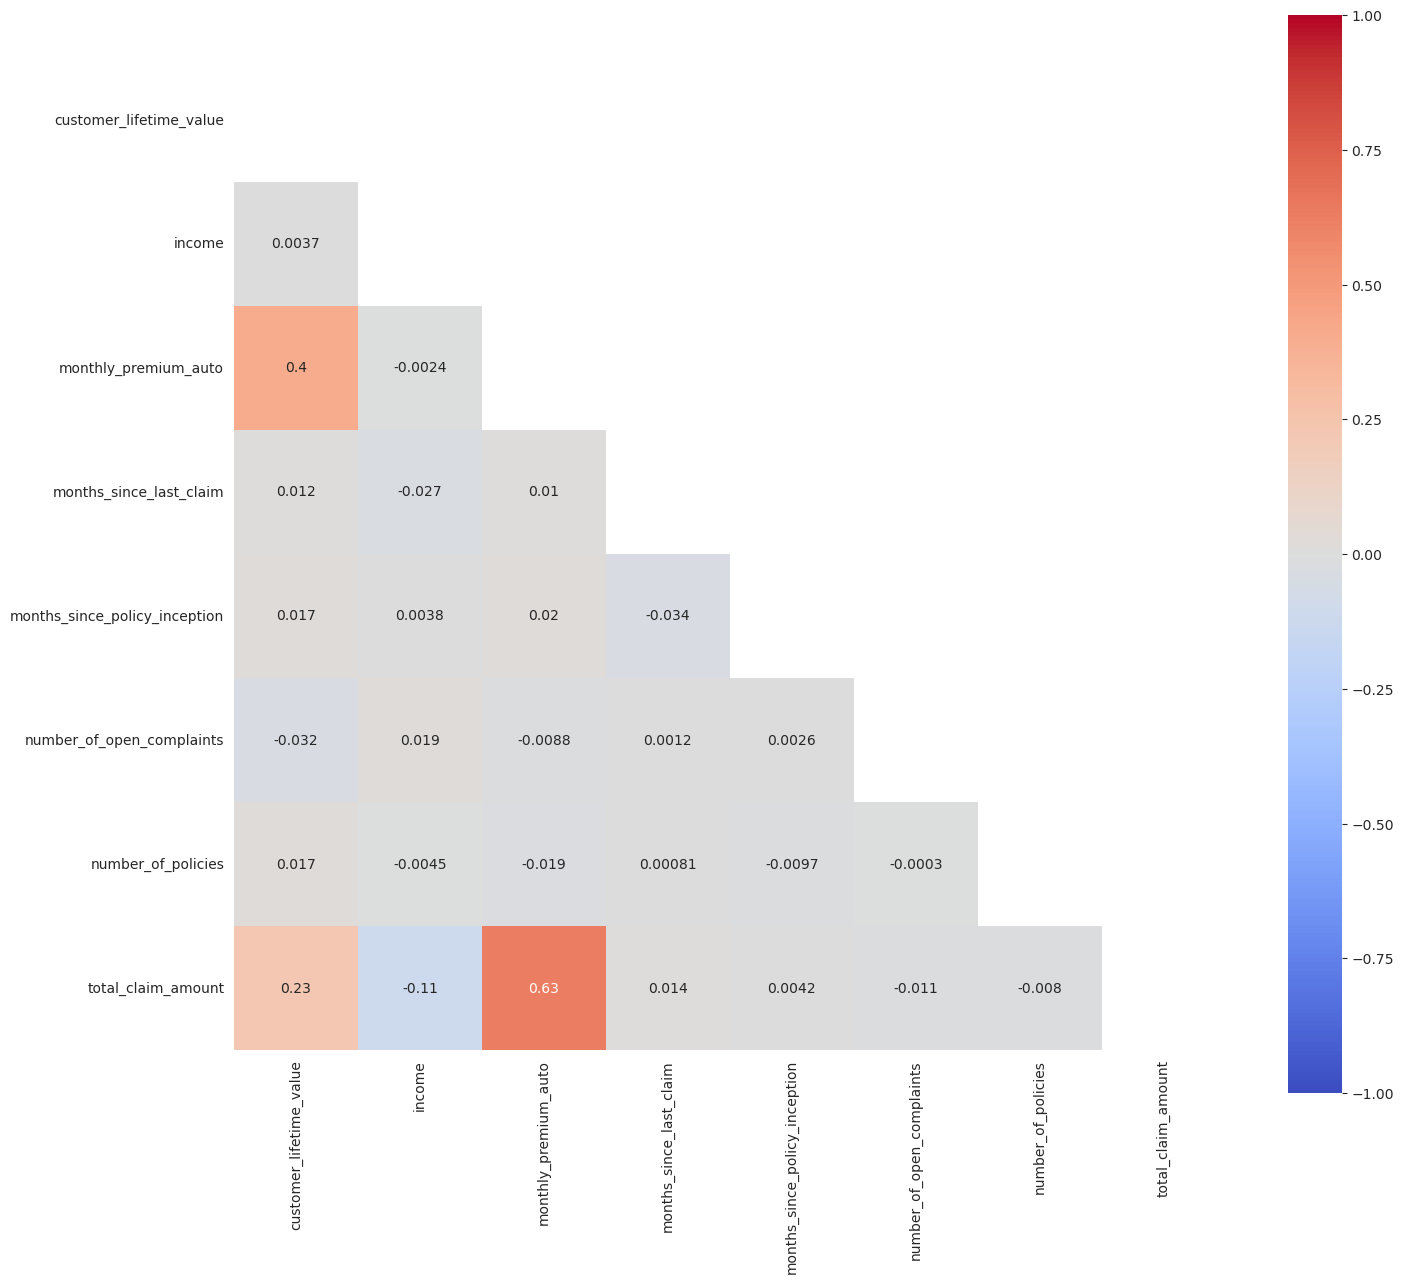

In [5]:
corr = dmca_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

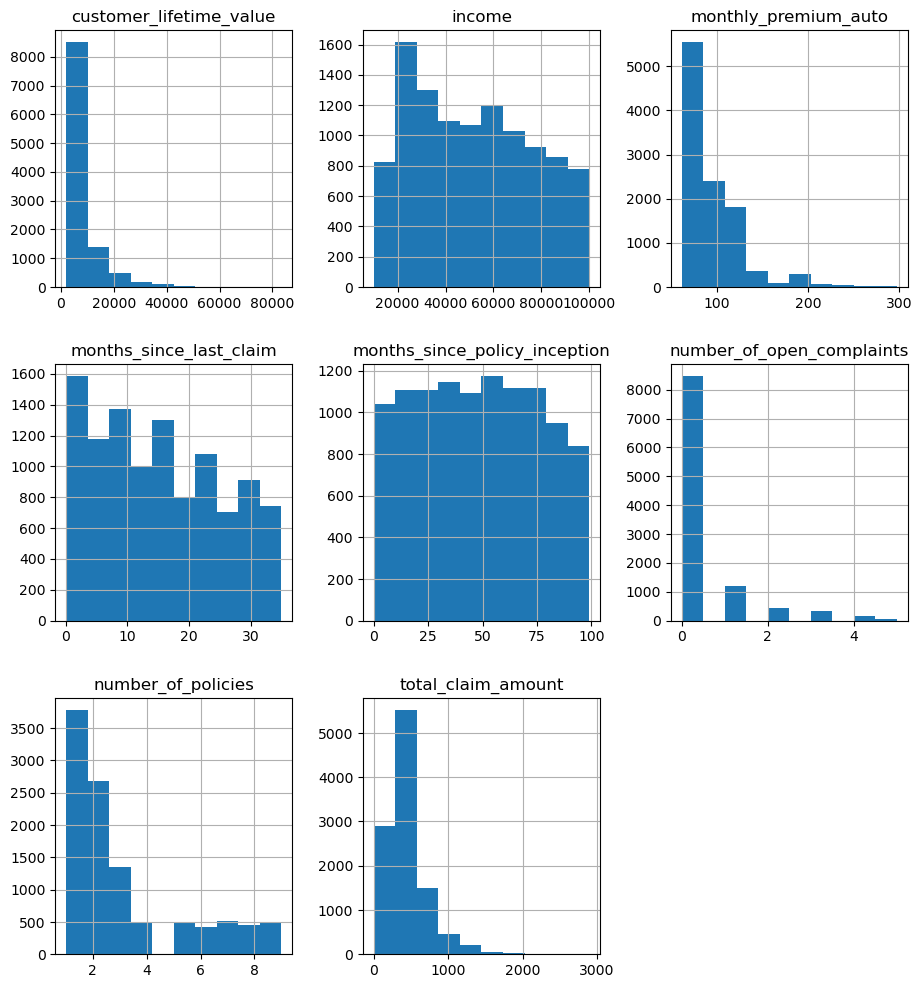

In [6]:
dmca_df.hist(figsize=(11,12))

#### removing highly correlated columns

In [7]:
CORR_THRESH = 0.80

corr_matrix=dmca_df.corr().abs()

upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]

dmca_df.drop(corrd_cols,axis=1,inplace=True)

dmca_df.columns  #on this dataset, there are no highly correlated columns

Index(['region', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'month', 'employment_status',
       'gender', 'income', 'location_code', 'marital_status',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

## X-y split (y is the target variable, which is the total claim amount)

In [8]:
X = dmca_df.drop('total_claim_amount', axis=1)
y = dmca_df.total_claim_amount


numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

/var/folders/b5/6jnrgrdn769_zhfz2sdxb88c0000gn/T/ipykernel_1300/4062120736.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


In [9]:
# test-train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train

,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
10423,west region,6582,no,premium,high school or below,1/17/11,jan,retired,m,10738,...,5,36,4,3,personal auto,personal l3,offer1,agent,four-door car,medsize
212,west region,3484,no,extended,bachelor,1/10/11,jan,employed,m,34307,...,33,62,2,1,personal auto,personal l3,offer1,call center,four-door car,medsize
9405,west region,4362,yes,premium,college,1/3/11,jan,employed,m,58842,...,6,74,0,1,personal auto,personal l3,offer2,branch,four-door car,medsize
3399,west region,25464,yes,extended,college,2/1/11,feb,retired,f,13663,...,1,66,0,2,corporate auto,corporate l3,offer1,branch,four-door car,small
505,west region,4516,no,extended,master,1/2/11,jan,unemployed,m,14018,...,29,9,0,1,corporate auto,corporate l3,offer2,call center,suv,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9785,west region,3086,no,extended,college,1/16/11,jan,employed,f,73938,...,34,48,0,1,personal auto,personal l3,offer4,call center,two-door car,medsize
959,north west,11177,no,basic,bachelor,1/16/11,jan,employed,m,20742,...,17,52,0,2,personal auto,personal l2,offer2,web,suv,medsize
7468,north west,4582,no,basic,bachelor,1/18/11,jan,employed,f,66991,...,1,71,0,1,personal auto,personal l3,offer2,branch,suv,medsize
5843,west region,8146,no,basic,college,2/27/11,feb,employed,f,92777,...,21,83,2,2,personal auto,personal l1,offer1,web,two-door car,medsize


### Standardize the data (after the data split).

In [10]:
ss = StandardScaler()
numericalX_transformed = ss.fit_transform(numericalX.to_numpy().reshape(-1,1))
# sns.displot(numericalX_transformed)

In [11]:
ct = ColumnTransformer([("ss", ss, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s


In [12]:
X_train = pd.DataFrame(X_train_ct)
X_test_ct

,ss__customer_lifetime_value,ss__income,ss__monthly_premium_auto,ss__months_since_last_claim,ss__months_since_policy_inception,ss__number_of_open_complaints,ss__number_of_policies
0,-0.046710,-1.290989,0.342865,-1.402410,-0.397754,-0.422899,0.424908
1,0.424394,-0.184680,1.330424,-1.104933,0.318320,-0.422899,0.008202
2,-0.110212,1.499242,-0.121868,0.184135,0.282517,-0.422899,0.008202
3,-0.295631,0.240044,-0.499464,0.084976,0.282517,-0.422899,0.008202
4,-0.233146,1.363789,0.168591,-0.113342,-0.003913,1.774279,2.508438
5,0.684358,-0.689401,-0.848014,1.374045,0.354124,-0.422899,-0.408504
6,1.233350,1.283550,1.272332,-0.906615,-1.221239,0.675690,-0.408504
7,-0.125469,0.480518,-0.034730,0.382454,-1.364454,-0.422899,0.008202
8,-0.452859,-0.857385,-0.877059,1.671522,0.318320,2.872868,0.841614
9,-0.814397,-1.270727,-0.789922,-1.204092,1.750469,-0.422899,-0.825210


### Apply linear regression and Model Interpretation

In [13]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     1059.
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:41:48   Log-Likelihood:                -72911.
No. Observations:               10669   AIC:                         1.458e+05
Df Residuals:                   10661   BIC:                         1.459e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        434.3072      2.177    199.519      0.0

In [14]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)   # model train

LinearRegression()